In [1]:
import numpy as np
import matplotlib.pyplot as plt

import random
import math

import cv2

In [2]:
ls

 Volume in drive C is Local Disk
 Volume Serial Number is 1A76-E077

 Directory of C:\Users\wkrtk\Desktop\DataScience\mask\mask

2020-09-23  오후 07:57    <DIR>          .
2020-09-23  오후 07:57    <DIR>          ..
2020-09-23  오후 07:33    <DIR>          .ipynb_checkpoints
2020-09-23  오후 06:18    <DIR>          dataset
2020-09-23  오후 06:35    <DIR>          frontalFace10
2020-09-23  오후 07:57           355,544 mask_Classification_SVM.ipynb
               1 File(s)        355,544 bytes
               5 Dir(s)  140,359,139,328 bytes free


In [3]:
basic_Path = './dataset/'

In [4]:
asd = None

In [5]:
str(type(asd))

"<class 'NoneType'>"

In [6]:
def getImageData(path) :
    
    orgImage_File = []
    grayImage_File = []
    
    for i in range(220) :
        
        image_Path = basic_Path + path + '/image_' + str(i) + '.png'
        
        image = cv2.imread(image_Path)
        
        if str(type(image)) != "<class 'NoneType'>" :
            
            orgImage_File.append(image)
            
            grayImage = cv2.cvtColor(image , cv2.COLOR_BGR2GRAY)
            grayImage_File.append(grayImage)
            
    return orgImage_File , grayImage_File

In [7]:
mask_Org , mask_Gray = getImageData('with_mask')

In [8]:
nomask_Org , nomask_Gray = getImageData('without_mask')

In [9]:
face_classifier = cv2.CascadeClassifier('frontalFace10/haarcascade_frontalface_default.xml')

In [114]:
test = nomask_Gray[0]

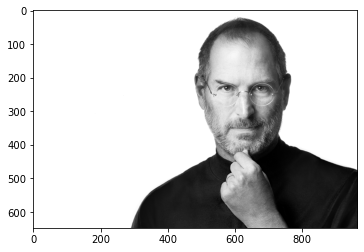

In [115]:
plt.imshow(test , cmap='gray')

In [13]:
location = face_classifier.detectMultiScale(test , 1.3 , 5)[0]

In [14]:
face_Height = [location[0] , location[0] + location[2]]
face_Width = [location[1] , location[1] + location[3]]

In [15]:
location

array([484, 118, 287, 287], dtype=int32)

In [16]:
face_Image = test[face_Width[0] : face_Width[1] , 
                 face_Height[0] : face_Height[1]]

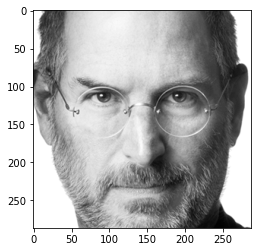

In [17]:
plt.imshow(face_Image , cmap='gray')

In [18]:
def getFaceImage(gray_image , org_image) :
    
    location = face_classifier.detectMultiScale(gray_image , 1.3 , 5)
    
    if len(location) > 0 :
    
        location = location[0]
    
        face_Height = [location[0] , location[0] + location[2]]
        face_Width = [location[1] , location[1] + location[3]]
        
        face_Image = org_image[face_Width[0] : face_Width[1] , 
                           face_Height[0] : face_Height[1]]
    
        return face_Image
    
    else :
        
        return -1

In [19]:
nomask_Face = []

for i in range(len(nomask_Org)) :
    
    face = getFaceImage(nomask_Gray[i] , nomask_Org[i])
    
    if str(type(face)) != "<class 'int'>"  :
    
        face = cv2.resize(face , (320, 320) , interpolation=cv2.INTER_LINEAR)
    
        nomask_Face.append(face)

In [20]:
print('Without Mask Data Length : %d' %len(nomask_Face))

Without Mask Data Length : 168


BGR Image // (index=144)


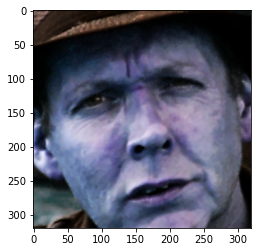

In [21]:
rand_Idx = np.random.choice(len(nomask_Face))

print('BGR Image // (index=%d)' %rand_Idx)

plt.imshow(nomask_Face[rand_Idx] , cmap='gray') 

In [22]:
mask_Face = []

for i in range(len(mask_Org)) :
    
    face = getFaceImage(mask_Gray[i] , mask_Org[i])
    
    if str(type(face)) != "<class 'int'>"  :
    
        face = cv2.resize(face , (320 , 320) , interpolation=cv2.INTER_LINEAR)
    
        mask_Face.append(face)

In [23]:
print('With Mask Data Length : %d' %len(mask_Face))

With Mask Data Length : 66


BGR Image // (index:48)


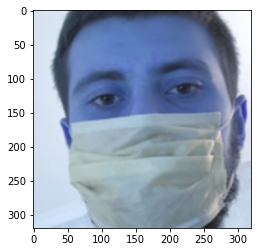

In [24]:
rand_Idx = np.random.choice(len(mask_Face))

print('BGR Image // (index:%d)' %rand_Idx)

plt.imshow(mask_Face[rand_Idx] , cmap='gray') 

# Machine Learning SVM

    1) With Mask Images : 66
    
    2) Without Mask Images : 168

In [80]:
# split Data

X_train = []
Y_train = []

X_test = []
Y_test=[]

In [81]:
def splitData(images , label , X_train , Y_train , X_test , Y_test) :
    
    length = len(images)
    
    limit = int(0.8 * length)
    
    for i in range(limit) :
        
        X_train.append(images[i])
        Y_train.append(label)
        
    for i in range(limit , length) :
        
        X_test.append(images[i])
        Y_test.append(label)
        

In [82]:
splitData(mask_Face , -1 , X_train , Y_train , X_test , Y_test)

In [83]:
splitData(nomask_Face , 1 , X_train , Y_train , X_test , Y_test)

In [84]:
def shuffleData(X , Y) :
    
    idx_List = list(range(len(X)))
    
    shuffle_List = random.sample(idx_List , len(X))
        
    new_X = []
    new_Y = []
        
    for idx in shuffle_List :
        
        new_X.append(X[idx])
        new_Y.append(Y[idx])            
                    
    return new_X , new_Y

In [85]:
X_train , Y_train = shuffleData(X_train , Y_train)

In [86]:
X_test , Y_test = shuffleData(X_test , Y_test)

# Get Features form ResNet50

In [87]:
from keras.applications.resnet50 import ResNet50

In [88]:
model = ResNet50(weights='imagenet' , 
                 input_shape=(320 , 320, 3) , 
                 include_top = False)

In [89]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)

X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [90]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn import svm

In [91]:
X_trainF = model.predict(X_train)

In [92]:
X_trainF.shape

(186, 10, 10, 2048)

In [93]:
X_trainF_re = X_trainF.reshape(len(X_trainF),-1)

In [94]:
X_testF = model.predict(X_test)

In [95]:
X_testF.shape

(48, 10, 10, 2048)

In [96]:
X_testF_re = X_testF.reshape(len(X_testF),-1)

In [97]:
# scale Transform
ss = StandardScaler()
ss.fit(X_trainF_re)

StandardScaler()

In [98]:
X_train_Scaled = ss.transform(X_trainF_re)
X_test_Scaled = ss.transform(X_testF_re)

In [141]:
# reduce dimension
pca = PCA(n_components= 32, whiten=True)
pca = pca.fit(X_train_Scaled)

X_train_PCA = pca.transform(X_train_Scaled)
X_test_PCA = pca.transform(X_test_Scaled)

# Training SVM

In [142]:
from sklearn.svm import SVC

In [143]:
svm = SVC(kernel='rbf' , C = 10 , gamma=0.01).fit(X_train_PCA , Y_train)

In [144]:
result = svm.predict(X_test_PCA)

In [145]:
acc = 0.0
tp = 0.0
fp = 0.0

tp_Length = 0.0
fp_Length = 0.0

for i in range(len(Y_test)) :
    
    if Y_test[i] == 1 :
        tp_Length += 1
        
    else :
        fp_Length += 1
        
    
    if Y_test[i] == result[i] :
        
        acc += 1
        
        if Y_test[i] == 1 :
            tp += 1
    
    else :
        
        if Y_test[i] == 1 :
            fp += 1
            
acc /= len(Y_test)
tp /= tp_Length
fp /= fp_Length

In [146]:
print('SVM Accuracy : %.3f' %acc)
print('SVM True Positive Rate : %.3f' %tp)
print('SVM False Positive Rate : %.3f' %fp)

SVM Accuracy : 0.979
SVM True Positive Rate : 0.971
SVM False Positive Rate : 0.071
